# Computer Vision Homework 3: Big vs Small Models

## Brief

Due date: Nov 16, 2022

Required files: `homework-3.ipynb`, `report.pdf`

To download the jupyter notebook from colab, you can refer to the colab tutorial we gave.


## Codes for Problem 1 and Problem 2

### Import Packages

In [151]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchvision import transforms, models, datasets
from tqdm import tqdm

%matplotlib inline

### Check GPU Environment

In [152]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cuda device


In [153]:
! nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-79830ca2-a70a-8f38-2080-0e7138528084)


### Set the Seed to Reproduce the Result

In [154]:
def set_all_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
set_all_seed(123)

### Create Dataset and Dataloader

In [155]:
batch_size = 256

train_transform = transforms.Compose([
    transforms.Pad(4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [156]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [157]:
train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=train_transform)
valid_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

sixteenth_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//16)
half_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//2)

sixteenth_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sixteenth_train_sampler)
half_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=half_train_sampler)

Files already downloaded and verified
Files already downloaded and verified


### Load Models

In [158]:
# HINT: Remember to change the model to 'resnet50' and the weights to weights="IMAGENET1K_V1" when needed.
model_small = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
model_small.fc.out_features = 10
model_small = model_small.to(device)
# print(model)

# Background: The original resnet18 is designed for ImageNet dataset to predict 1000 classes.
# TODO: Change the output of the model to 10 class.

Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


### Training and Testing Models

In [159]:
# TODO: Fill in the code cell according to the pytorch tutorial we gave.
def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0
    
    model.train()

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred = pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)

            epoch_loss += loss_fn(pred, y).item()
            pred = pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

In [218]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [206]:
epochs_small = 15
epochs_big = 15

## Training Small model and testing

In [198]:
# Use sixteenth_train_dataloader
model_small = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
model_small.fc.out_features = 10
model_small = model_small.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer_small = torch.optim.Adam(model_small.parameters(), lr=1e-3)

for epoch in range(epochs_small):
    train_loss, train_acc = train(sixteenth_train_dataloader, model_small, loss_fn, optimizer_small)
    test_loss, test_acc = test(valid_dataloader, model_small, loss_fn)
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")

print("Done!")

Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch  1: Loss = 3.3091 Acc = 0.02 Test_Loss = 3.2612 Test_Acc = 0.13
Epoch  2: Loss = 1.8299 Acc = 0.02 Test_Loss = 3.1211 Test_Acc = 0.18
Epoch  3: Loss = 1.7134 Acc = 0.02 Test_Loss = 2.9764 Test_Acc = 0.19
Epoch  4: Loss = 1.6684 Acc = 0.02 Test_Loss = 2.0777 Test_Acc = 0.31
Epoch  5: Loss = 1.5995 Acc = 0.03 Test_Loss = 1.6366 Test_Acc = 0.41
Epoch  6: Loss = 1.5976 Acc = 0.03 Test_Loss = 1.6037 Test_Acc = 0.41
Epoch  7: Loss = 1.5272 Acc = 0.03 Test_Loss = 1.5862 Test_Acc = 0.44
Epoch  8: Loss = 1.5267 Acc = 0.03 Test_Loss = 1.4347 Test_Acc = 0.48
Epoch  9: Loss = 1.4490 Acc = 0.03 Test_Loss = 1.5719 Test_Acc = 0.44
Epoch 10: Loss = 1.4667 Acc = 0.03 Test_Loss = 1.4705 Test_Acc = 0.46
Epoch 11: Loss = 1.4707 Acc = 0.03 Test_Loss = 1.5094 Test_Acc = 0.44
Epoch 12: Loss = 1.4481 Acc = 0.03 Test_Loss = 1.4554 Test_Acc = 0.47
Epoch 13: Loss = 1.4228 Acc = 0.03 Test_Loss = 1.5419 Test_Acc = 0.45
Epoch 14: Loss = 1.3973 Acc = 0.03 Test_Loss = 1.6101 Test_Acc = 0.41
Epoch 15: Loss = 1.3

In [200]:
# Use half_train_dataloader
model_small = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
model_small.fc.out_features = 10
model_small = model_small.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer_small = torch.optim.Adam(model_small.parameters(), lr=1e-3)

for epoch in range(epochs_small):
    train_loss, train_acc = train(half_train_dataloader, model_small, loss_fn, optimizer_small)
    test_loss, test_acc = test(valid_dataloader, model_small, loss_fn)
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")

print("Done!")

Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch  1: Loss = 1.8158 Acc = 0.20 Test_Loss = 1.6211 Test_Acc = 0.43
Epoch  2: Loss = 1.3729 Acc = 0.25 Test_Loss = 1.3587 Test_Acc = 0.50
Epoch  3: Loss = 1.2230 Acc = 0.28 Test_Loss = 1.3703 Test_Acc = 0.53
Epoch  4: Loss = 1.1456 Acc = 0.29 Test_Loss = 1.2932 Test_Acc = 0.56
Epoch  5: Loss = 1.0667 Acc = 0.31 Test_Loss = 1.1287 Test_Acc = 0.61
Epoch  6: Loss = 1.0098 Acc = 0.32 Test_Loss = 1.2087 Test_Acc = 0.58
Epoch  7: Loss = 0.9668 Acc = 0.33 Test_Loss = 1.8140 Test_Acc = 0.46
Epoch  8: Loss = 0.9261 Acc = 0.34 Test_Loss = 1.3533 Test_Acc = 0.55
Epoch  9: Loss = 0.8771 Acc = 0.34 Test_Loss = 1.1341 Test_Acc = 0.62
Epoch 10: Loss = 0.8411 Acc = 0.35 Test_Loss = 1.0882 Test_Acc = 0.63
Epoch 11: Loss = 0.8294 Acc = 0.35 Test_Loss = 0.9506 Test_Acc = 0.67
Epoch 12: Loss = 0.7978 Acc = 0.36 Test_Loss = 1.0269 Test_Acc = 0.65
Epoch 13: Loss = 0.7674 Acc = 0.36 Test_Loss = 0.8899 Test_Acc = 0.70
Epoch 14: Loss = 0.7453 Acc = 0.37 Test_Loss = 0.7902 Test_Acc = 0.73
Epoch 15: Loss = 0.7

In [201]:
# Use train_dataloader
model_small = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
model_small.fc.out_features = 10
model_small = model_small.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer_small = torch.optim.Adam(model_small.parameters(), lr=1e-3)

for epoch in range(epochs_small):
    train_loss, train_acc = train(train_dataloader, model_small, loss_fn, optimizer_small)
    test_loss, test_acc = test(valid_dataloader, model_small, loss_fn)
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")

print("Done!")

Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch  1: Loss = 1.6063 Acc = 0.44 Test_Loss = 1.8887 Test_Acc = 0.38
Epoch  2: Loss = 1.1733 Acc = 0.58 Test_Loss = 1.4876 Test_Acc = 0.51
Epoch  3: Loss = 1.0274 Acc = 0.64 Test_Loss = 1.3198 Test_Acc = 0.56
Epoch  4: Loss = 0.9248 Acc = 0.67 Test_Loss = 1.0287 Test_Acc = 0.65
Epoch  5: Loss = 0.8593 Acc = 0.70 Test_Loss = 0.9880 Test_Acc = 0.66
Epoch  6: Loss = 0.7985 Acc = 0.72 Test_Loss = 1.1908 Test_Acc = 0.60
Epoch  7: Loss = 0.7528 Acc = 0.73 Test_Loss = 1.0012 Test_Acc = 0.65
Epoch  8: Loss = 0.7138 Acc = 0.75 Test_Loss = 0.7953 Test_Acc = 0.73
Epoch  9: Loss = 0.6817 Acc = 0.76 Test_Loss = 0.8354 Test_Acc = 0.71
Epoch 10: Loss = 0.6504 Acc = 0.77 Test_Loss = 0.8343 Test_Acc = 0.72
Epoch 11: Loss = 0.6278 Acc = 0.78 Test_Loss = 0.9020 Test_Acc = 0.70
Epoch 12: Loss = 0.5898 Acc = 0.79 Test_Loss = 0.8108 Test_Acc = 0.73
Epoch 13: Loss = 0.5826 Acc = 0.79 Test_Loss = 0.6821 Test_Acc = 0.76
Epoch 14: Loss = 0.5551 Acc = 0.81 Test_Loss = 0.8288 Test_Acc = 0.72
Epoch 15: Loss = 0.5

## Training Big modle and testing

In [207]:
# Use sixteenth_train_dataloader
model_big = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)
model_big.fc.out_features = 10
model_big = model_big.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer_big = torch.optim.Adam(model_big.parameters(), lr=1e-3)

for epoch in range(epochs_big):
    train_loss, train_acc = train(sixteenth_train_dataloader, model_big, loss_fn, optimizer_big)
    test_loss, test_acc = test(valid_dataloader, model_big, loss_fn)
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
print("Done!")

Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch  1: Loss = 3.1537 Acc = 0.01 Test_Loss = 2.5314 Test_Acc = 0.10
Epoch  2: Loss = 2.2305 Acc = 0.01 Test_Loss = 2.6589 Test_Acc = 0.10
Epoch  3: Loss = 2.0594 Acc = 0.02 Test_Loss = 2.1857 Test_Acc = 0.19
Epoch  4: Loss = 2.0064 Acc = 0.02 Test_Loss = 1.9874 Test_Acc = 0.27
Epoch  5: Loss = 1.9464 Acc = 0.02 Test_Loss = 1.9091 Test_Acc = 0.31
Epoch  6: Loss = 1.9610 Acc = 0.02 Test_Loss = 1.8244 Test_Acc = 0.37
Epoch  7: Loss = 1.8766 Acc = 0.02 Test_Loss = 2.2989 Test_Acc = 0.38
Epoch  8: Loss = 1.8338 Acc = 0.02 Test_Loss = 2.6227 Test_Acc = 0.36
Epoch  9: Loss = 1.8283 Acc = 0.02 Test_Loss = 2.0510 Test_Acc = 0.39
Epoch 10: Loss = 1.7918 Acc = 0.02 Test_Loss = 1.7615 Test_Acc = 0.38
Epoch 11: Loss = 1.7463 Acc = 0.02 Test_Loss = 1.6838 Test_Acc = 0.42
Epoch 12: Loss = 1.7342 Acc = 0.02 Test_Loss = 1.6315 Test_Acc = 0.43
Epoch 13: Loss = 1.6767 Acc = 0.03 Test_Loss = 1.6206 Test_Acc = 0.42
Epoch 14: Loss = 1.6852 Acc = 0.03 Test_Loss = 1.6199 Test_Acc = 0.42
Epoch 15: Loss = 1.6

In [209]:
# Use half_train_dataloader
model_big = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)
model_big.fc.out_features = 10
model_big = model_big.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer_big = torch.optim.Adam(model_big.parameters(), lr=1e-3)

for epoch in range(epochs_big):
    train_loss, train_acc = train(half_train_dataloader, model_big, loss_fn, optimizer_big)
    test_loss, test_acc = test(valid_dataloader, model_big, loss_fn)
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
print("Done!")

Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch  1: Loss = 2.1046 Acc = 0.14 Test_Loss = 1.7188 Test_Acc = 0.39
Epoch  2: Loss = 1.6716 Acc = 0.20 Test_Loss = 1.5399 Test_Acc = 0.43
Epoch  3: Loss = 1.5553 Acc = 0.22 Test_Loss = 1.4065 Test_Acc = 0.49
Epoch  4: Loss = 1.5001 Acc = 0.23 Test_Loss = 1.5446 Test_Acc = 0.47
Epoch  5: Loss = 1.4294 Acc = 0.24 Test_Loss = 1.6473 Test_Acc = 0.48
Epoch  6: Loss = 1.3789 Acc = 0.26 Test_Loss = 1.3719 Test_Acc = 0.51
Epoch  7: Loss = 1.3209 Acc = 0.27 Test_Loss = 1.3886 Test_Acc = 0.49
Epoch  8: Loss = 1.3754 Acc = 0.26 Test_Loss = 1.4347 Test_Acc = 0.50
Epoch  9: Loss = 1.2997 Acc = 0.27 Test_Loss = 1.3381 Test_Acc = 0.54
Epoch 10: Loss = 1.2011 Acc = 0.29 Test_Loss = 1.1576 Test_Acc = 0.59
Epoch 11: Loss = 1.2347 Acc = 0.28 Test_Loss = 1.1120 Test_Acc = 0.60
Epoch 12: Loss = 1.2386 Acc = 0.29 Test_Loss = 1.5142 Test_Acc = 0.56
Epoch 13: Loss = 1.2595 Acc = 0.29 Test_Loss = 9.4886 Test_Acc = 0.32
Epoch 14: Loss = 1.4727 Acc = 0.25 Test_Loss = 1.9753 Test_Acc = 0.46
Epoch 15: Loss = 1.4

In [210]:
# Use train_dataloader
model_big = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)
model_big.fc.out_features = 10
model_big = model_big.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer_big = torch.optim.Adam(model_big.parameters(), lr=1e-3)

for epoch in range(epochs_big):
    train_loss, train_acc = train(train_dataloader, model_big, loss_fn, optimizer_big)
    test_loss, test_acc = test(valid_dataloader, model_big, loss_fn)
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
print("Done!")

Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch  1: Loss = 1.9242 Acc = 0.34 Test_Loss = 1.6143 Test_Acc = 0.44
Epoch  2: Loss = 1.5375 Acc = 0.46 Test_Loss = 1.7066 Test_Acc = 0.52
Epoch  3: Loss = 1.4559 Acc = 0.49 Test_Loss = 3.9190 Test_Acc = 0.49
Epoch  4: Loss = 1.3676 Acc = 0.53 Test_Loss = 1.4539 Test_Acc = 0.55
Epoch  5: Loss = 1.3413 Acc = 0.53 Test_Loss = 1.2871 Test_Acc = 0.56
Epoch  6: Loss = 1.2642 Acc = 0.56 Test_Loss = 1.2044 Test_Acc = 0.61
Epoch  7: Loss = 1.1446 Acc = 0.60 Test_Loss = 1.4724 Test_Acc = 0.58
Epoch  8: Loss = 1.1566 Acc = 0.60 Test_Loss = 1.2187 Test_Acc = 0.60
Epoch  9: Loss = 1.1359 Acc = 0.61 Test_Loss = 11.0713 Test_Acc = 0.37
Epoch 10: Loss = 1.1375 Acc = 0.60 Test_Loss = 45.5376 Test_Acc = 0.25
Epoch 11: Loss = 1.5140 Acc = 0.48 Test_Loss = 1.6398 Test_Acc = 0.47
Epoch 12: Loss = 1.3260 Acc = 0.53 Test_Loss = 1.1422 Test_Acc = 0.60
Epoch 13: Loss = 1.4892 Acc = 0.49 Test_Loss = 1.8774 Test_Acc = 0.35
Epoch 14: Loss = 1.5633 Acc = 0.45 Test_Loss = 1.6101 Test_Acc = 0.50
Epoch 15: Loss = 1

## Drawing Picture

In [168]:
zero_point_two_train_sampler = RandomSampler(train_dataset, num_samples=int(len(train_dataset) * 0.2))
zero_point_four_train_sampler = RandomSampler(train_dataset, num_samples=int(len(train_dataset) * 0.4))
zero_point_six_train_sampler = RandomSampler(train_dataset, num_samples=int(len(train_dataset) * 0.6))
zero_point_eight_train_sampler = RandomSampler(train_dataset, num_samples=int(len(train_dataset) * 0.8))

zero_point_two_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=zero_point_two_train_sampler)
zero_point_four_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=zero_point_four_train_sampler)
zero_point_six_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=zero_point_six_train_sampler)
zero_point_eight_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=zero_point_eight_train_sampler)

dataloaders = [zero_point_two_train_dataloader, zero_point_four_train_dataloader,
               zero_point_six_train_dataloader, zero_point_eight_train_dataloader,
               train_dataloader]

In [169]:
# training ResNet18 from datasize 0.2 to datasize 1.0
small_model_acc = [] # 0.2, 0.4, 0.6, 0.8, 1.0 (dataset size)

for idx, dataloader in enumerate(dataloaders):
    loss_fn = nn.CrossEntropyLoss()
    model_small = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
    model_small.fc.out_features = 10
    model_small = model_small.to(device)
    optimizer_small = torch.optim.Adam(model_small.parameters(), lr=1e-3)

    for epoch in range(epochs_small):
        train_loss, train_acc = train(dataloader, model_small, loss_fn, optimizer_small)
        test_loss, test_acc = test(valid_dataloader, model_small, loss_fn)
        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
    small_model_acc.append(test_acc)
    
    print("="*25 + "Complete "+str(idx+1)+" dataloader"+"="*25)
print("Done!")

Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch  1: Loss = 2.2479 Acc = 0.06 Test_Loss = 2.3212 Test_Acc = 0.24
Epoch  2: Loss = 1.5823 Acc = 0.08 Test_Loss = 1.4485 Test_Acc = 0.48
Epoch  3: Loss = 1.5141 Acc = 0.09 Test_Loss = 2.0357 Test_Acc = 0.35
Epoch  4: Loss = 1.4216 Acc = 0.10 Test_Loss = 1.3917 Test_Acc = 0.49
Epoch  5: Loss = 1.3805 Acc = 0.10 Test_Loss = 1.6905 Test_Acc = 0.43
Epoch  6: Loss = 1.3262 Acc = 0.10 Test_Loss = 1.5252 Test_Acc = 0.45
Epoch  7: Loss = 1.2757 Acc = 0.11 Test_Loss = 1.8909 Test_Acc = 0.39
Epoch  8: Loss = 1.2477 Acc = 0.11 Test_Loss = 2.4362 Test_Acc = 0.32
Epoch  9: Loss = 1.2248 Acc = 0.11 Test_Loss = 2.4921 Test_Acc = 0.33
Epoch 10: Loss = 1.1839 Acc = 0.12 Test_Loss = 1.2946 Test_Acc = 0.53
Epoch 11: Loss = 1.1531 Acc = 0.12 Test_Loss = 1.3163 Test_Acc = 0.54
Epoch 12: Loss = 1.0991 Acc = 0.12 Test_Loss = 1.1777 Test_Acc = 0.58
Epoch 13: Loss = 1.0876 Acc = 0.12 Test_Loss = 2.4353 Test_Acc = 0.35
Epoch 14: Loss = 1.0863 Acc = 0.12 Test_Loss = 1.2811 Test_Acc = 0.58
Epoch 15: Loss = 1.1

Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch  1: Loss = 1.8931 Acc = 0.15 Test_Loss = 1.5395 Test_Acc = 0.44
Epoch  2: Loss = 1.4543 Acc = 0.19 Test_Loss = 2.4409 Test_Acc = 0.27
Epoch  3: Loss = 1.2985 Acc = 0.21 Test_Loss = 1.3745 Test_Acc = 0.50
Epoch  4: Loss = 1.2136 Acc = 0.23 Test_Loss = 1.4139 Test_Acc = 0.51
Epoch  5: Loss = 1.1377 Acc = 0.24 Test_Loss = 1.6143 Test_Acc = 0.46
Epoch  6: Loss = 1.0767 Acc = 0.25 Test_Loss = 1.3943 Test_Acc = 0.55
Epoch  7: Loss = 1.0245 Acc = 0.25 Test_Loss = 1.2809 Test_Acc = 0.57
Epoch  8: Loss = 0.9878 Acc = 0.26 Test_Loss = 1.1167 Test_Acc = 0.61
Epoch  9: Loss = 0.9563 Acc = 0.26 Test_Loss = 1.4628 Test_Acc = 0.52
Epoch 10: Loss = 0.9251 Acc = 0.27 Test_Loss = 1.0887 Test_Acc = 0.64
Epoch 11: Loss = 0.8774 Acc = 0.27 Test_Loss = 1.0405 Test_Acc = 0.64
Epoch 12: Loss = 0.8738 Acc = 0.28 Test_Loss = 1.0690 Test_Acc = 0.63
Epoch 13: Loss = 0.8350 Acc = 0.28 Test_Loss = 0.9390 Test_Acc = 0.68
Epoch 14: Loss = 0.8035 Acc = 0.29 Test_Loss = 1.3879 Test_Acc = 0.57
Epoch 15: Loss = 0.8

Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch  1: Loss = 1.7519 Acc = 0.24 Test_Loss = 2.1814 Test_Acc = 0.32
Epoch  2: Loss = 1.3326 Acc = 0.31 Test_Loss = 1.2929 Test_Acc = 0.53
Epoch  3: Loss = 1.1946 Acc = 0.34 Test_Loss = 1.5590 Test_Acc = 0.46
Epoch  4: Loss = 1.0812 Acc = 0.37 Test_Loss = 1.0427 Test_Acc = 0.63
Epoch  5: Loss = 1.0054 Acc = 0.39 Test_Loss = 1.0468 Test_Acc = 0.63
Epoch  6: Loss = 0.9550 Acc = 0.40 Test_Loss = 1.4888 Test_Acc = 0.52
Epoch  7: Loss = 0.8987 Acc = 0.41 Test_Loss = 0.8627 Test_Acc = 0.70
Epoch  8: Loss = 0.8482 Acc = 0.42 Test_Loss = 1.1294 Test_Acc = 0.61
Epoch  9: Loss = 0.8326 Acc = 0.43 Test_Loss = 1.1686 Test_Acc = 0.62
Epoch 10: Loss = 0.7883 Acc = 0.43 Test_Loss = 0.9430 Test_Acc = 0.67
Epoch 11: Loss = 0.7556 Acc = 0.44 Test_Loss = 0.8893 Test_Acc = 0.70
Epoch 12: Loss = 0.7316 Acc = 0.45 Test_Loss = 1.0027 Test_Acc = 0.66
Epoch 13: Loss = 0.7127 Acc = 0.45 Test_Loss = 0.8252 Test_Acc = 0.71
Epoch 14: Loss = 0.6866 Acc = 0.46 Test_Loss = 0.8231 Test_Acc = 0.72
Epoch 15: Loss = 0.6

Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch  1: Loss = 1.6588 Acc = 0.34 Test_Loss = 1.4882 Test_Acc = 0.47
Epoch  2: Loss = 1.2508 Acc = 0.44 Test_Loss = 1.3828 Test_Acc = 0.53
Epoch  3: Loss = 1.0842 Acc = 0.49 Test_Loss = 1.2985 Test_Acc = 0.56
Epoch  4: Loss = 0.9957 Acc = 0.52 Test_Loss = 1.1050 Test_Acc = 0.60
Epoch  5: Loss = 0.9282 Acc = 0.54 Test_Loss = 1.0957 Test_Acc = 0.62
Epoch  6: Loss = 0.8575 Acc = 0.56 Test_Loss = 1.0068 Test_Acc = 0.65
Epoch  7: Loss = 0.8160 Acc = 0.57 Test_Loss = 0.9515 Test_Acc = 0.68
Epoch  8: Loss = 0.7755 Acc = 0.58 Test_Loss = 1.2426 Test_Acc = 0.60
Epoch  9: Loss = 0.7390 Acc = 0.59 Test_Loss = 1.1695 Test_Acc = 0.63
Epoch 10: Loss = 0.7133 Acc = 0.60 Test_Loss = 0.9776 Test_Acc = 0.67
Epoch 11: Loss = 0.6834 Acc = 0.61 Test_Loss = 0.7875 Test_Acc = 0.74
Epoch 12: Loss = 0.6716 Acc = 0.61 Test_Loss = 1.4136 Test_Acc = 0.58
Epoch 13: Loss = 0.6403 Acc = 0.62 Test_Loss = 0.7686 Test_Acc = 0.73
Epoch 14: Loss = 0.6188 Acc = 0.63 Test_Loss = 0.7068 Test_Acc = 0.75
Epoch 15: Loss = 0.5

Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch  1: Loss = 1.6002 Acc = 0.44 Test_Loss = 1.5063 Test_Acc = 0.48
Epoch  2: Loss = 1.1886 Acc = 0.57 Test_Loss = 1.3700 Test_Acc = 0.51
Epoch  3: Loss = 1.0302 Acc = 0.63 Test_Loss = 1.5914 Test_Acc = 0.46
Epoch  4: Loss = 0.9372 Acc = 0.67 Test_Loss = 1.3025 Test_Acc = 0.57
Epoch  5: Loss = 0.8658 Acc = 0.69 Test_Loss = 1.0282 Test_Acc = 0.64
Epoch  6: Loss = 0.8019 Acc = 0.72 Test_Loss = 0.9798 Test_Acc = 0.67
Epoch  7: Loss = 0.7547 Acc = 0.73 Test_Loss = 0.8598 Test_Acc = 0.71
Epoch  8: Loss = 0.7095 Acc = 0.75 Test_Loss = 0.9659 Test_Acc = 0.68
Epoch  9: Loss = 0.6769 Acc = 0.76 Test_Loss = 0.7308 Test_Acc = 0.75
Epoch 10: Loss = 0.6425 Acc = 0.78 Test_Loss = 0.6566 Test_Acc = 0.77
Epoch 11: Loss = 0.6241 Acc = 0.78 Test_Loss = 0.6686 Test_Acc = 0.77
Epoch 12: Loss = 0.5897 Acc = 0.79 Test_Loss = 0.7002 Test_Acc = 0.76
Epoch 13: Loss = 0.5748 Acc = 0.80 Test_Loss = 1.1594 Test_Acc = 0.65
Epoch 14: Loss = 0.5589 Acc = 0.81 Test_Loss = 0.6676 Test_Acc = 0.77
Epoch 15: Loss = 0.5

In [214]:
# Training ResNet50 from datasize 0.2 to datasize 1.0
big_model_acc = []

for idx, dataloader in enumerate(dataloaders):
    model_big = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)
    model_big.fc.out_features = 10
    model_big = model_big.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer_big = torch.optim.Adam(model_big.parameters(), lr=1e-3)
    early_stopper = EarlyStopper(patience=3, min_delta=10)
    
    for epoch in range(100):
        train_loss, train_acc = train(dataloader, model_big, loss_fn, optimizer_big)
        test_loss, test_acc = test(valid_dataloader, model_big, loss_fn)
        if early_stopper.early_stop(test_loss):
            break
        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
    big_model_acc.append(test_acc)
    print("="*25 + "Complete "+str(idx+1)+" dataloader"+"="*25)
    
print("Done!")

Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch  1: Loss = 2.5130 Acc = 0.04 Test_Loss = 2.3449 Test_Acc = 0.18
Epoch 11: Loss = 1.5348 Acc = 0.09 Test_Loss = 1.4754 Test_Acc = 0.48
Epoch 21: Loss = 1.3288 Acc = 0.11 Test_Loss = 1.3747 Test_Acc = 0.52
Epoch 31: Loss = 1.3250 Acc = 0.11 Test_Loss = 1.2612 Test_Acc = 0.54
Epoch 41: Loss = 1.1796 Acc = 0.12 Test_Loss = 1.3153 Test_Acc = 0.57
Epoch 51: Loss = 1.2902 Acc = 0.11 Test_Loss = 10.0008 Test_Acc = 0.32
Epoch 61: Loss = 1.5858 Acc = 0.09 Test_Loss = 1.4073 Test_Acc = 0.48
Epoch 71: Loss = 1.4562 Acc = 0.10 Test_Loss = 2.5466 Test_Acc = 0.50
Epoch 81: Loss = 1.3360 Acc = 0.11 Test_Loss = 8.3978 Test_Acc = 0.48
Epoch 91: Loss = 1.3137 Acc = 0.11 Test_Loss = 1.1918 Test_Acc = 0.58
Epoch 100: Loss = 1.0213 Acc = 0.13 Test_Loss = 1.1277 Test_Acc = 0.60
=========================Complete 1 dataloader=========================


Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch  1: Loss = 2.1638 Acc = 0.11 Test_Loss = 1.8202 Test_Acc = 0.36
Epoch 11: Loss = 1.3263 Acc = 0.22 Test_Loss = 14.9251 Test_Acc = 0.37
Epoch 21: Loss = 1.1400 Acc = 0.24 Test_Loss = 1.0761 Test_Acc = 0.62
Epoch 31: Loss = 0.9451 Acc = 0.27 Test_Loss = 0.9994 Test_Acc = 0.65
Epoch 41: Loss = 0.9676 Acc = 0.26 Test_Loss = 0.9150 Test_Acc = 0.69
Epoch 51: Loss = 1.0674 Acc = 0.25 Test_Loss = 0.9965 Test_Acc = 0.69
Epoch 61: Loss = 1.1253 Acc = 0.24 Test_Loss = 1.1517 Test_Acc = 0.60
Epoch 71: Loss = 0.7721 Acc = 0.29 Test_Loss = 0.8148 Test_Acc = 0.72
Epoch 81: Loss = 0.7644 Acc = 0.29 Test_Loss = 0.7230 Test_Acc = 0.75
Epoch 91: Loss = 0.9507 Acc = 0.27 Test_Loss = 1.0059 Test_Acc = 0.68
Epoch 100: Loss = 0.7503 Acc = 0.30 Test_Loss = 0.7705 Test_Acc = 0.73
=========================Complete 2 dataloader=========================


Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch  1: Loss = 2.0702 Acc = 0.18 Test_Loss = 1.8240 Test_Acc = 0.39
Epoch 11: Loss = 1.1203 Acc = 0.36 Test_Loss = 1.2093 Test_Acc = 0.58
Epoch 21: Loss = 0.8592 Acc = 0.42 Test_Loss = 1.3750 Test_Acc = 0.55
Epoch 31: Loss = 0.6410 Acc = 0.47 Test_Loss = 1.3000 Test_Acc = 0.59
Epoch 41: Loss = 0.7151 Acc = 0.45 Test_Loss = 1.1301 Test_Acc = 0.64
Epoch 51: Loss = 0.6093 Acc = 0.47 Test_Loss = 0.6592 Test_Acc = 0.77
Epoch 61: Loss = 0.4846 Acc = 0.50 Test_Loss = 0.6310 Test_Acc = 0.79
Epoch 71: Loss = 0.4753 Acc = 0.50 Test_Loss = 0.5671 Test_Acc = 0.81
Epoch 81: Loss = 0.3986 Acc = 0.52 Test_Loss = 0.5500 Test_Acc = 0.82
Epoch 91: Loss = 0.3384 Acc = 0.53 Test_Loss = 0.6030 Test_Acc = 0.80
Epoch 100: Loss = 0.2880 Acc = 0.54 Test_Loss = 0.5223 Test_Acc = 0.84
=========================Complete 3 dataloader=========================


Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch  1: Loss = 1.9687 Acc = 0.25 Test_Loss = 1.6445 Test_Acc = 0.42
Epoch 11: Loss = 1.3838 Acc = 0.42 Test_Loss = 1.4551 Test_Acc = 0.48
Epoch 21: Loss = 0.8564 Acc = 0.56 Test_Loss = 1.0994 Test_Acc = 0.63
Epoch 31: Loss = 0.8668 Acc = 0.56 Test_Loss = 0.8180 Test_Acc = 0.71
Epoch 41: Loss = 0.9184 Acc = 0.54 Test_Loss = 0.8358 Test_Acc = 0.71
Epoch 51: Loss = 0.5278 Acc = 0.65 Test_Loss = 0.6609 Test_Acc = 0.78
Epoch 61: Loss = 0.4247 Acc = 0.68 Test_Loss = 0.5519 Test_Acc = 0.81
Epoch 71: Loss = 0.4090 Acc = 0.68 Test_Loss = 0.6408 Test_Acc = 0.79
Epoch 81: Loss = 0.3229 Acc = 0.71 Test_Loss = 0.6106 Test_Acc = 0.81
Epoch 91: Loss = 0.2677 Acc = 0.72 Test_Loss = 0.5373 Test_Acc = 0.83
Epoch 100: Loss = 0.2189 Acc = 0.74 Test_Loss = 0.5403 Test_Acc = 0.84
=========================Complete 4 dataloader=========================


Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch  1: Loss = 1.9228 Acc = 0.34 Test_Loss = 1.6023 Test_Acc = 0.42
Epoch 11: Loss = 1.2357 Acc = 0.57 Test_Loss = 1.4845 Test_Acc = 0.52
Epoch 21: Loss = 0.8317 Acc = 0.71 Test_Loss = 3.0241 Test_Acc = 0.42
Epoch 31: Loss = 1.1464 Acc = 0.60 Test_Loss = 1.2976 Test_Acc = 0.57
Epoch 41: Loss = 0.5993 Acc = 0.79 Test_Loss = 0.6351 Test_Acc = 0.79
Epoch 51: Loss = 0.4193 Acc = 0.85 Test_Loss = 0.6512 Test_Acc = 0.79
Epoch 61: Loss = 0.3702 Acc = 0.87 Test_Loss = 0.5666 Test_Acc = 0.82
Epoch 71: Loss = 0.4063 Acc = 0.86 Test_Loss = 0.5658 Test_Acc = 0.81
Epoch 81: Loss = 0.2420 Acc = 0.91 Test_Loss = 0.6836 Test_Acc = 0.83
Epoch 91: Loss = 0.1993 Acc = 0.93 Test_Loss = 0.7368 Test_Acc = 0.83
Epoch 100: Loss = 0.1630 Acc = 0.94 Test_Loss = 0.6111 Test_Acc = 0.84
=========================Complete 5 dataloader=========================
Done!


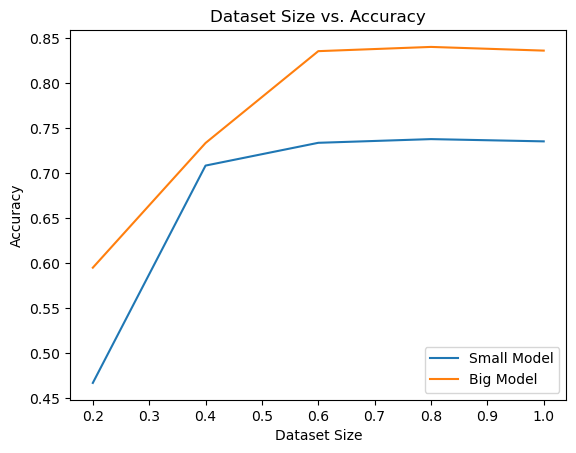

In [215]:
dataset_size = [0.2, 0.4, 0.6, 0.8, 1.0]

plt.plot(dataset_size, small_model_acc, label='Small Model')
plt.plot(dataset_size, big_model_acc, label = 'Big Model')
plt.title('Dataset Size vs. Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Dataset Size')
plt.legend(loc="lower right")

plt.show()

## Codes for Problem 3

In [219]:
# TODO: Try to achieve the best performance given all training data using whatever model and training strategy.

# Try early stop during training and epochs=200
# Use train_dataloader

model_big = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights='IMAGENET1K_V1')
model_big.fc.out_features = 10
model_big = model_big.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer_big = torch.optim.Adam(model_big.parameters(), lr=1e-3)
early_stopper = EarlyStopper(patience=3, min_delta=10)

for epoch in range(100):
    train_loss, train_acc = train(half_train_dataloader, model_big, loss_fn, optimizer_big)
    test_loss, test_acc = test(valid_dataloader, model_big, loss_fn)
    if early_stopper.early_stop(test_loss):
        break
    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
print("Done!")

Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch  1: Loss = 1.4693 Acc = 0.29 Test_Loss = 0.8863 Test_Acc = 0.72
Epoch 11: Loss = 0.4278 Acc = 0.43 Test_Loss = 0.4733 Test_Acc = 0.84
Epoch 21: Loss = 0.3274 Acc = 0.44 Test_Loss = 0.4781 Test_Acc = 0.84
Epoch 31: Loss = 0.5990 Acc = 0.40 Test_Loss = 0.5952 Test_Acc = 0.80
Epoch 41: Loss = 0.2940 Acc = 0.45 Test_Loss = 0.4776 Test_Acc = 0.84
Epoch 51: Loss = 0.2393 Acc = 0.46 Test_Loss = 0.4377 Test_Acc = 0.86
Epoch 61: Loss = 0.2124 Acc = 0.46 Test_Loss = 0.4442 Test_Acc = 0.86
Epoch 71: Loss = 0.5015 Acc = 0.41 Test_Loss = 0.9344 Test_Acc = 0.70
Epoch 81: Loss = 0.1839 Acc = 0.47 Test_Loss = 0.4514 Test_Acc = 0.87
Epoch 91: Loss = 0.1496 Acc = 0.47 Test_Loss = 0.4555 Test_Acc = 0.87
Epoch 100: Loss = 0.1368 Acc = 0.48 Test_Loss = 0.4938 Test_Acc = 0.86
Done!


In [217]:
# model with weight=IMAGENET1K_V1

model_big = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights='IMAGENET1K_V1')
model_big.fc.out_features = 10
model_big = model_big.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer_big = torch.optim.Adam(model_big.parameters(), lr=1e-3)

# sixteenth_train_dataloader
for epoch in range(15):
    train_loss, train_acc = train(sixteenth_train_dataloader, model_big, loss_fn, optimizer_big)
    test_loss, test_acc = test(valid_dataloader, model_big, loss_fn)
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
print("Done!")

Using cache found in C:\Users\Kyle/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch  1: Loss = 3.7380 Acc = 0.02 Test_Loss = 19.5495 Test_Acc = 0.22
Epoch  2: Loss = 1.4233 Acc = 0.03 Test_Loss = 1.9448 Test_Acc = 0.49
Epoch  3: Loss = 1.2347 Acc = 0.03 Test_Loss = 1.2518 Test_Acc = 0.59
Epoch  4: Loss = 1.1441 Acc = 0.04 Test_Loss = 1.0542 Test_Acc = 0.64
Epoch  5: Loss = 1.0321 Acc = 0.04 Test_Loss = 1.0304 Test_Acc = 0.65
Epoch  6: Loss = 0.9337 Acc = 0.04 Test_Loss = 0.9595 Test_Acc = 0.67
Epoch  7: Loss = 0.9145 Acc = 0.04 Test_Loss = 0.8327 Test_Acc = 0.72
Epoch  8: Loss = 0.8551 Acc = 0.04 Test_Loss = 0.8325 Test_Acc = 0.72
Epoch  9: Loss = 0.8417 Acc = 0.04 Test_Loss = 0.8528 Test_Acc = 0.71
Epoch 10: Loss = 0.7946 Acc = 0.05 Test_Loss = 0.7489 Test_Acc = 0.75
Epoch 11: Loss = 0.7683 Acc = 0.05 Test_Loss = 0.8558 Test_Acc = 0.71
Epoch 12: Loss = 0.8020 Acc = 0.05 Test_Loss = 0.8307 Test_Acc = 0.72
Epoch 13: Loss = 0.7854 Acc = 0.04 Test_Loss = 0.8347 Test_Acc = 0.72
Epoch 14: Loss = 0.7941 Acc = 0.05 Test_Loss = 0.7996 Test_Acc = 0.73
Epoch 15: Loss = 0.

## Problems

1. (30%) Finish the rest of the codes for Problem 1 and Problem 2 according to the hint. (2 code cells in total.)
2. Train small model (resnet18) and big model (resnet50) from scratch on `sixteenth_train_dataloader`, `half_train_dataloader`, and `train_dataloader` respectively.
3. (30%) Achieve the best performance given all training data using whatever model and training strategy.  
  (You cannot use the model that was pretrained on CIFAR10)



## Discussion


- (30%) The relationship between the accuracy, model size, and the training dataset size.  
    (Total 6 models. Small model trains on the sixteenth, half, and all data. Big model trains on the sixteenth, half, and all data.)
    - 在 epochs = 15 的形況下，考慮 dataset size， size 越大則 test accuaracy 越好。這和我們預想的符合，不論是在 small model or big model 都有這樣的結果。
    - 然而在相同的 dataset size 中， small model 的表現比 big model 較好。這可能是因為我們的 epochs 太小，使得 ResNet50 還沒充分訓練完。
    - | | ResNet18| ResNet50|
      | ---| ---|---|
      | Sixteenth| 0.4 | 0.44 |
      | Half | 0.69 | 0.56 |
      | Full | 0.74 | 0.60|
      
    - 當 epochs = 100 時，我們用 half_train_dataloader 來訓練 ResNet50，test accuracy 為 0.81，明顯比 ResNet18 好。
      
      
- (10%) What if we train the ResNet with ImageNet initialized weights (`weights="IMAGENET1K_V1"`), how would the relationship change?
    - 可以發現在 `sixteenth_train_dataloader` 上，一樣跑 epochs = 15， test accuracy 明顯好很多，甚至比用 Full 還要好!
    - | | ResNet50 | ResNet50 (with `weight=IMAGENET1K_V1`) |
      |-| -------- | ---------------------------------------|
      | Sixteenth | 0.44 | 0.75 |
      | Full | 0.6 | 0.86 |

## Credits

1. [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)